In [1]:
#Import
import imageio
import argparse
import os
import random
import shutil
from datetime import datetime
import numpy as np
import csv
import torch
import torch.backends.cudnn as cudnn
import torch.multiprocessing as mp
import torch.optim as optim
import torch.utils.data
from torch.utils.tensorboard import SummaryWriter
from model_all import VideoDataSet, HNeRV, HNeRVDecoder, TransformInput
from hnerv_utils import *
from torch.utils.data import Subset
from copy import deepcopy 
from dahuffman import HuffmanCodec
from torchvision.utils import save_image
import pandas as pd
import decord
import time
import matplotlib.pyplot as plt

import torch.nn.utils.prune as prune

/ext3/miniconda3/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
#Replace argparse from default HNeRV code
class Argparse():
    
    def __init__(self,
                 data_path,
                 vid,
                 checkpoint_pth,
                shuffle_data = True ,
                finetune_ep = [10,20,30,40,50],
                base_prune_ratio = 0.60,
                prune_ratio_step = 0.10,
                data_split = '1_1_1' ,
                crop_list = '640_1280' ,
                resize_list = '-1',
                embed =  '' ,
                ks = '0_3_3' ,
                enc_strds = [] ,
                enc_dim = '64_16' ,
                modelsize = 1.5 ,
                saturate_stages = -1 ,
                fc_hw = '9_16' ,
                reduce = 1.2 ,
                lower_width = 32 ,
                dec_strds = [5, 3, 2, 2, 2] ,
                num_blks = '1_1' ,
                conv_type = ['convnext', 'pshuffel'],
                norm = 'none' ,
                act = 'gelu' ,
                workers = 4, 
                batchSize = 1 ,
                start_epoch = -1 ,
                not_resume = True ,
                epochs = 5 ,
                block_params = '1_1' ,
                lr = '0.001' ,
                lr_type = 'cosine_0.1_1_0.1' ,
                loss = 'Fusion6' ,
                out_bias = 'tanh' ,
                eval_only = False ,
                eval_freq = '10' ,
                quant_model_bit = 8 ,
                quant_embed_bit = 6 ,
                quant_axis = '0.0' ,
                dump_images = False ,
                dump_videos = False ,
                eval_fps = False ,
                encoder_file = '' ,
                manualSeed = 1337 ,
                distributed = False ,
                debug = False ,
                print_freq = 50 ,
                weight = 'None' ,
                overwrite = True ,
                outf = 'unify' ,
                super = False,
                super_rate = 2,
                suffix = ''):

        #Set param
        self.data_path = data_path
        self.checkpoint_pth = checkpoint_pth
        self.vid = vid
        self.shuffle_data  = shuffle_data
        self.data_split = data_split
        self.crop_list = crop_list
        self.resize_list = resize_list
        self.embed = embed
        self.ks = ks
        self.enc_strds = enc_strds
        self.enc_dim = enc_dim
        self.modelsize = modelsize
        self.saturate_stages = saturate_stages
        self.fc_hw = fc_hw
        self.reduce = reduce
        self.lower_width = lower_width
        self.dec_strds = dec_strds
        self.num_blks = num_blks
        self.conv_type = conv_type
        self.norm = norm
        self.act = act
        self.workers = workers
        self.batchSize = batchSize
        self.start_epoch = start_epoch
        self.not_resume = not_resume
        self.epochs = epochs
        self.block_params = block_params
        self.lr = lr
        self.lr_type = lr_type
        self.loss = loss
        self.out_bias = out_bias
        self.eval_only = eval_only
        self.eval_freq = eval_freq
        self.quant_model_bit = quant_model_bit
        self.quant_embed_bit = quant_embed_bit
        self.quant_axis = quant_axis
        self.dump_images = dump_images
        self.dump_videos = dump_videos
        self.eval_fps = eval_fps
        self.encoder_file = encoder_file
        self.manualSeed = manualSeed
        self.distributed = distributed
        self.debug = debug
        self.print_freq = print_freq
        self.weight = weight
        self.overwrite = overwrite
        self.outf = outf
        self.suffix = suffix      
        self.compression_method = 'huffman'
        self.super = super
        self.super_rate = super_rate
        self.eval_quant_overall_PSNR = 0
        self.eval_orig_overall_PSNR = 0
        self.finetune_ep = finetune_ep
        self.base_prune_ratio = base_prune_ratio
        self.prune_ratio_step = prune_ratio_step

In [3]:
#Init
torch.set_printoptions(precision=4) 

args = Argparse(data_path='/scratch/ar7996/ivp/uvgdataset/Beauty_3840x2160_120fps_420_8bit_YUV_RAW/Beauty_3840x2160_YUV_444_1920x1080_cropped_images/',
                vid='prune_test_beauty_2_oriquantize_QM6_2x',
                checkpoint_pth='/scratch/kl3866/IVP/HNeRV/batches/final/2x_1080_HNeRV_gamut/2x_HNeRV_gamut/2x_Beauty_QTM32_QTE6/1_1_1__Dim64_16_FC9_16_KS0_1_5_RED1.2_low12_blk1_1_e600_b1_quant_M32_E6_lr0.001_cosine_0.1_1_0.1_L2_Size1.5_ENC_convnext_5,4,4,3,2_DEC_pshuffel_5,4,4,3,2_gelu1_1/',
                outf='new_prune_test_4_2x',
                base_prune_ratio=0.05,
                prune_ratio_step=0.05,
                super=True,
                super_rate=2,
                loss='L2',
                crop_list='960_1920',
                enc_strds=np.array([5,4,4,3,2]),
                dec_strds=np.array([5,4,4,3,2]),
                enc_dim='64_16',
                ks='0_1_5',
                reduce=1.2,
                eval_freq=5,
                lower_width=12,
                batchSize=1,
                lr=0.001,
                eval_only=False,
#                 weight="checkpoints/hnerv-1.5m-e300.pth",
                dump_images=True,
                finetune_ep=[0,10,20,30,
                             50,70,90,110,
                             140,170,200,230,
                             270,310,350,390,
                             440,500,570,650], 
                epochs=651,
                quant_model_bit=6
               )

In [16]:
#Init
torch.set_printoptions(precision=4) 

args = Argparse(data_path='/scratch/ar7996/ivp/uvgdataset/Beauty_3840x2160_120fps_420_8bit_YUV_RAW/Beauty_3840x2160_YUV_444_1920x1080_cropped_images/',
                vid='large_embed_beauty_1_MAXVAL256_2x',
                checkpoint_pth='/scratch/kl3866/IVP/HNeRV/batches/final/2x_1080_HNeRV_gamut/2x_HNeRV_gamut/2x_Beauty_QTM32_QTE6/1_1_1__Dim64_16_FC9_16_KS0_1_5_RED1.2_low12_blk1_1_e600_b1_quant_M32_E6_lr0.001_cosine_0.1_1_0.1_L2_Size1.5_ENC_convnext_5,4,4,3,2_DEC_pshuffel_5,4,4,3,2_gelu1_1/',
                outf='large_embed_test_0_2x',
                base_prune_ratio=0.8,
                prune_ratio_step=0.05,
                super=True,
                super_rate=2,
                loss='L2',
                crop_list='960_1920',
                enc_strds=np.array([5,4,3,2,2]),
                dec_strds=np.array([5,4,3,2,2]),
                enc_dim='64_16',
                ks='0_1_5',
                reduce=1.2,
                eval_freq=5,
                lower_width=12,
                batchSize=1,
                lr=0.001,
                eval_only=False,
#                 weight="checkpoints/hnerv-1.5m-e300.pth",
                dump_images=True,
                finetune_ep = [0,1,2],
#                 finetune_ep=[0,20,50, #x
#                              100,160], 
                epochs=3,
                quant_model_bit=8
               )

In [4]:
def main():
    torch.set_printoptions(precision=4) 
    if args.debug:
        args.eval_freq = 1
        args.outf = 'output/debug'
    else:
        args.outf = os.path.join('output', args.outf)

    args.enc_strd_str, args.dec_strd_str = ','.join([str(x) for x in args.enc_strds]), ','.join([str(x) for x in args.dec_strds])
    extra_str = 'Size{}_ENC_{}_{}_DEC_{}_{}_{}{}{}'.format(args.modelsize, args.conv_type[0], args.enc_strd_str, 
        args.conv_type[1], args.dec_strd_str, '' if args.norm == 'none' else f'_{args.norm}', 
        '_dist' if args.distributed else '', '_shuffle_data' if args.shuffle_data else '',)
    args.quant_str = f'quant_M{args.quant_model_bit}_E{args.quant_embed_bit}'
    embed_str = f'{args.embed}_Dim{args.enc_dim}'
    exp_id = f'{args.vid}/{args.data_split}_{embed_str}_FC{args.fc_hw}_KS{args.ks}_RED{args.reduce}_low{args.lower_width}_blk{args.num_blks}' + \
            f'_e{args.epochs}_b{args.batchSize}_{args.quant_str}_lr{args.lr}_{args.lr_type}_{args.loss}_{extra_str}{args.act}{args.block_params}{args.suffix}'
    args.exp_id = exp_id

    args.outf = os.path.join(args.outf, exp_id)
    if args.overwrite and os.path.isdir(args.outf):
        print('Will overwrite the existing output dir!')
#         raise Exception("Warning overwriting stuff, break!")
        shutil.rmtree(args.outf)

    if not os.path.isdir(args.outf):
        os.makedirs(args.outf)

    port = hash(args.exp_id) % 20000 + 10000
    args.init_method =  f'tcp://127.0.0.1:{port}'
    print(f'init_method: {args.init_method}', flush=True)

    torch.set_printoptions(precision=2) 
    args.ngpus_per_node = torch.cuda.device_count()
    if args.distributed and args.ngpus_per_node > 1:
        mp.spawn(train, nprocs=args.ngpus_per_node, args=(args,))
    else:
        return train(None, args)

In [5]:
def data_to_gpu(x, device):
    return x.to(device)



--------
### New Train Func

In [6]:
#New train func
def prune(model,ratio=0.05):
    
    #Count params first
    param_ct = 0

    for k,v in model.state_dict().items():

        #Only count decoder and head layer
        if 'decoder' in k or 'head' in k:
            params = np.prod(v.shape)
            param_ct += params

            
    #Count zeros (most important)
    ori_zero_count = 0

    for k,v in model.state_dict().items():

        #Only count decoder and head layer
        if 'decoder' in k or 'head' in k:
            ct = int((v==0).sum())
            ori_zero_count += ct
            
            
    #Assemble params to prune
    to_prune = []
    
    #No need to check for weights in head_layer since it's fully convolutional; all trainable and prunable
    if model.head_layer != 'Conv2d':
        for i in model.head_layer:
            to_prune.append((i,'weight'))
            to_prune.append((i,'bias'))
            
    elif model.head_layer == 'Conv2d': #for case without super-res
        to_prune.append((model.head_layer,'weight'))
        to_prune.append((model.head_layer,'bias'))


    #Need to check for decoder
    for i in model.decoder:

        if 'weight' in dir(i) and 'NeRV' not in i.__repr__():
            to_prune.append((i,'weight'))
            to_prune.append((i,'bias'))

        elif 'NeRV' in i.__repr__():

            #Iter through NeRV block
            for j in i.modules():
                if 'weight' in dir(j): #if with prunable params
                    to_prune.append((j,'weight'))
                    to_prune.append((j,'bias'))
                    
                    
    #Prune
    import torch.nn.utils.prune as prune

    prune.global_unstructured(
        to_prune,
        pruning_method=prune.L1Unstructured,
        amount=ratio,
    )
    
    #Remove
    for i in to_prune:
        prune.remove(*i)
        
        
    #Count zeros (most important)
    pruned_zero_count = 0

    for k,v in model.state_dict().items():

        #Only count decoder and head layer
        if 'decoder' in k or 'head' in k:
            ct = int((v==0).sum())
            pruned_zero_count += ct
            
    #Compute compression ratio
    actual_ratio = pruned_zero_count / param_ct
    estimated_rateio = ratio
            
    return model,pruned_zero_count,estimated_rateio,actual_ratio



def train(local_rank, args):
    cudnn.benchmark = True
    torch.manual_seed(args.manualSeed)
    np.random.seed(args.manualSeed)
    random.seed(args.manualSeed)

    if args.distributed and args.ngpus_per_node > 1:
        torch.distributed.init_process_group(
            backend='nccl',
            init_method=args.init_method,
            world_size=args.ngpus_per_node,
            rank=local_rank,
        )
        torch.cuda.set_device(local_rank)
        assert torch.distributed.is_initialized()        
        args.batchSize = int(args.batchSize / args.ngpus_per_node)

    args.metric_names = ['pred_seen_psnr', 'pred_seen_ssim', 'pred_unseen_psnr', 'pred_unseen_ssim',
        'quant_seen_psnr', 'quant_seen_ssim', 'quant_unseen_psnr', 'quant_unseen_ssim']
    best_metric_list = [torch.tensor(0) for _ in range(len(args.metric_names))]

    # setup dataloader    
    full_dataset = VideoDataSet(args)
    sampler = torch.utils.data.distributed.DistributedSampler(full_dataset) if args.distributed else None
    full_dataloader = torch.utils.data.DataLoader(full_dataset, batch_size=args.batchSize, shuffle=(sampler is None),
            num_workers=args.workers, pin_memory=True, sampler=sampler, drop_last=False, worker_init_fn=worker_init_fn)
    args.final_size = full_dataset.final_size
    args.full_data_length = len(full_dataset)
    split_num_list = [int(x) for x in args.data_split.split('_')]
    train_ind_list, args.val_ind_list = data_split(list(range(args.full_data_length)), split_num_list, args.shuffle_data, 0)
    args.dump_vis = (args.dump_images or args.dump_videos)

    #  Make sure the testing dataset is fixed for every run
    train_dataset =  Subset(full_dataset, train_ind_list)
    train_sampler = torch.utils.data.distributed.DistributedSampler(train_dataset) if args.distributed else None
    train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=args.batchSize, shuffle=(train_sampler is None),
         num_workers=args.workers, pin_memory=True, sampler=train_sampler, drop_last=True, worker_init_fn=worker_init_fn)
         
    #Re init a new dataloader WITHOUT shuffling for eval
    full_dataloader_noshuffle = torch.utils.data.DataLoader(full_dataset, batch_size=args.batchSize, 
                                                                shuffle=False, num_workers=args.workers,
                                                                pin_memory=True, sampler=sampler, 
                                                                drop_last=False, worker_init_fn=worker_init_fn)

    # Compute the parameter number
    if 'pe' in args.embed or 'le' in args.embed:
        embed_param = 0
        embed_dim = int(args.embed.split('_')[-1]) * 2
        fc_param = np.prod([int(x) for x in args.fc_hw.split('_')])
    else:
        total_enc_strds = np.prod(args.enc_strds)
        embed_hw = args.final_size / total_enc_strds**2
        enc_dim1, embed_ratio = [float(x) for x in args.enc_dim.split('_')]
        embed_dim = int(embed_ratio * args.modelsize * 1e6 / args.full_data_length / embed_hw) if embed_ratio < 1 else int(embed_ratio) 
        embed_param = float(embed_dim) / total_enc_strds**2 * args.final_size * args.full_data_length
        args.enc_dim = f'{int(enc_dim1)}_{embed_dim}' 
        fc_param = (np.prod(args.enc_strds) // np.prod(args.dec_strds))**2 * 9

    decoder_size = args.modelsize * 1e6 - embed_param
    ch_reduce = 1. / args.reduce
    dec_ks1, dec_ks2 = [int(x) for x in args.ks.split('_')[1:]]
    fix_ch_stages = len(args.dec_strds) if args.saturate_stages == -1 else args.saturate_stages
    a =  ch_reduce * sum([ch_reduce**(2*i) * s**2 * min((2*i + dec_ks1), dec_ks2)**2 for i,s in enumerate(args.dec_strds[:fix_ch_stages])])
    b =  embed_dim * fc_param 
    c =  args.lower_width **2 * sum([s**2 * min(2*(fix_ch_stages + i) + dec_ks1, dec_ks2)  **2 for i, s in enumerate(args.dec_strds[fix_ch_stages:])])
    args.fc_dim = int(np.roots([a,b,c - decoder_size]).max())

    # Building model
    model = HNeRV(args)

    # Update model here if super-res | HACKY PATCH, integrate formally if works later
    if args.super:

        #Import 
        import torch.nn as nn
        from torchmetrics.image.lpip import LearnedPerceptualImagePatchSimilarity

        #Check loss function
        assert args.loss in ['Super-L1','Super-L2','L2','L1'], Exception("Error! Super-res enabled but loss function is {}; use Super-L1 or Super-L2 instead.".format(args.loss))
      
        #Get original model head_layer's input channel
        head_in_channel = model.head_layer.in_channels

        #Determine head layer param based on super-res ratio
        if args.super_rate == 2:
            transpose_stride = 2 
            depth_kernel = 2
            depth_padding = 1
        elif args.super_rate == 4:
            transpose_stride = 4 
            depth_kernel = 3
            depth_padding = 3

        model.head_layer = nn.Sequential(nn.ConvTranspose2d(head_in_channel,head_in_channel,3,transpose_stride,1),
                                       nn.Conv2d(head_in_channel,head_in_channel, depth_kernel, groups=head_in_channel,padding=depth_padding),#depthwise conv
                                       nn.Conv2d(head_in_channel,3, 1,)) #pointwise conv output

        #New loss function
        criterionLPIPS = LearnedPerceptualImagePatchSimilarity(net_type='squeeze')


    ##### get model params and flops #####
    if local_rank in [0, None]:
        encoder_param = (sum([p.data.nelement() for p in model.encoder.parameters()]) / 1e6) 
        decoder_param = (sum([p.data.nelement() for p in model.decoder.parameters()]) / 1e6) 
        total_param = decoder_param + embed_param / 1e6
        args.encoder_param, args.decoder_param, args.total_param = encoder_param, decoder_param, total_param
        param_str = f'Encoder_{round(encoder_param, 2)}M_Decoder_{round(decoder_param, 2)}M_Total_{round(total_param, 2)}M'
        print(f'{args}\n {model}\n {param_str}', flush=True)
        with open('{}/rank0.txt'.format(args.outf), 'a') as f:
            f.write(str(model) + '\n' + f'{param_str}\n')
        writer = SummaryWriter(os.path.join(args.outf, param_str, 'tensorboard'))
    else:
        writer = None

    # distrite model to gpu or parallel
    print("Use GPU: {} for training".format(local_rank))
    if args.distributed and args.ngpus_per_node > 1:
        model = torch.nn.parallel.DistributedDataParallel(model.to(local_rank), device_ids=[local_rank], output_device=local_rank, find_unused_parameters=False)
        
        #Do not support distributed training for super-res yet
        if args.super:
            raise Exception("Warning, support for distributed training + Super-Res with perceptual loss is not supported in current code yet")
    
    elif args.ngpus_per_node > 1:
        model = torch.nn.DataParallel(model)

        #Do not support distributed training for super-res yet
        if args.super:
            raise Exception("Warning, support for distributed training + Super-Res with perceptual loss is not supported in current code yet")
    
    elif torch.cuda.is_available():
        model = model.cuda()
        
        if args.super:
            criterionLPIPS = criterionLPIPS.to('cuda')

    optimizer = optim.Adam(model.parameters(), weight_decay=0.)
    args.transform_func = TransformInput(args)


    #Load pretrained model to prune
    checkpoint_path = os.path.join(args.checkpoint_pth, 'model_latest.pth')
    
    assert os.path.isfile(checkpoint_path), Exception("No pretrained model found!")
    checkpoint = torch.load(checkpoint_path, map_location='cpu')
    model.load_state_dict(checkpoint['state_dict'])
    print("=> Auto resume loaded checkpoint '{}' (epoch {})".format(checkpoint_path, checkpoint['epoch']))

    #Set start epoch at 0 again for finetuning
    args.start_epoch = 0
    

#     if args.start_epoch < 0:
#         if checkpoint is not None:
#             args.start_epoch = checkpoint['epoch'] 
#         args.start_epoch = max(args.start_epoch, 0)

#     if args.eval_only:

#         print_str = 'Evaluation ... \n {} Results for checkpoint: {}\n'.format(datetime.now().strftime('%Y_%m_%d_%H_%M_%S'), args.weight)
#         results_list, hw = evaluate(model, full_dataloader_noshuffle, local_rank, args, args.dump_vis, args.compression_method)
#         print_str = f'PSNR for output {hw} for quant {args.quant_str}: '
#         for i, (metric_name, best_metric_value, metric_value) in enumerate(zip(args.metric_names, best_metric_list, results_list)):
#             best_metric_value = best_metric_value if best_metric_value > metric_value.max() else metric_value.max()
#             cur_v = RoundTensor(best_metric_value, 2 if 'psnr' in metric_name else 4)
#             print_str += f'best_{metric_name}: {cur_v} | '
#             best_metric_list[i] = best_metric_value
#         if local_rank in [0, None]:
#             print(print_str, flush=True)
#             with open('{}/eval.txt'.format(args.outf), 'a') as f:
#                 f.write(print_str + '\n\n')        
#             args.train_time, args.cur_epoch = 0, args.epochs
#             Dump2CSV(args, best_metric_list, results_list, [torch.tensor(0)], 'eval.csv')

#         return


    # Training
    start = datetime.now()

    #Init vars
    psnr_list = []
    args.finetune_ep = np.array(args.finetune_ep)
    
    #Vars to track time
    raw_fp_encode_time = 0
    raw_fu_encode_time = 0
    
    for epoch in range(args.start_epoch, args.epochs):
        model.train()       
        epoch_start_time = datetime.now()
        pred_psnr_list = []
        
        # iterate over dataloader
        device = next(model.parameters()).device
        
        #Prune model
        if epoch in args.finetune_ep:
            index = (args.finetune_ep==epoch).argmax()
            ratio = np.clip(args.base_prune_ratio + (((args.prune_ratio_step) * index)),0,1)            
#             print('>>',index,(args.finetune_ep==epoch).argmax(),ratio)
            
            model,pruned_zero_count,estimated_ratio,actual_ratio = prune(model,ratio=ratio)
            
                    
            print("===="*30)
            print("Ratio Input: {}".format(ratio))
            print("Prune Ratio (Est): {} | Prune Ratio (Act): {} | #Zeros: {}".format(estimated_ratio,actual_ratio,pruned_zero_count))
            print("Ep {} of [{}]".format(epoch,args.finetune_ep))
            
            
        #Store info
        args.estimated_prune_ratio = estimated_ratio 
        args.actual_prune_ratio = actual_ratio
        args.pruned_zero_count = pruned_zero_count
        
        print((epoch + 1), args.finetune_ep, (epoch + 1) in args.finetune_ep)
        
        for i, sample in enumerate(train_dataloader):
            
            #Start Track time (full)
            start_time_fu = time.time()
            
            img_data, img_down_data, norm_idx, img_idx = data_to_gpu(sample['img'], device), data_to_gpu(sample['img_down'], device),data_to_gpu(sample['norm_idx'], device), data_to_gpu(sample['idx'], device)
            if i > 10 and args.debug:
                break
                
            #Overwrite for super-res
            if args.super:
                img_gt = img_data
                img_data = img_down_data
            else: 
                img_gt = img_data
            
            cur_input = norm_idx if 'pe' in args.embed else img_data
            cur_epoch = (epoch + float(i) / len(train_dataloader)) / args.epochs
            lr = adjust_lr(optimizer, cur_epoch, args)
            img_out, _, _, encode_time = model(cur_input)
            
            #End track time (full)
            end_time_fu = time.time()
            delta_fu = end_time_fu - start_time_fu
            delta_fp = encode_time
            
            raw_fp_encode_time += delta_fp
            raw_fu_encode_time += delta_fu
            
            
            final_loss = loss_fn(img_out, img_gt, args.loss,
                                 LPIPS = criterionLPIPS if args.super else None)      
            optimizer.zero_grad()
            final_loss.backward()
            optimizer.step()

            pred_psnr_list.append(psnr_fn_single(img_out.detach(), img_gt)) 
            if i % args.print_freq == 0 or i == len(train_dataloader) - 1:
                pred_psnr = torch.cat(pred_psnr_list).mean()
                print_str = '[{}] Rank:{}, Epoch[{}/{}], Step [{}/{}], lr:{:.2e} pred_PSNR: {}'.format(
                    datetime.now().strftime("%Y/%m/%d %H:%M:%S"), local_rank, epoch+1, args.epochs, i+1, len(train_dataloader), lr, 
                    RoundTensor(pred_psnr, 2))
                print(print_str, flush=True)
                if local_rank in [0, None]:
                    with open('{}/rank0.txt'.format(args.outf), 'a') as f:
                        f.write(print_str + '\n')

        # collect numbers from other gpus
        if args.distributed and args.ngpus_per_node > 1:
            pred_psnr = all_reduce([pred_psnr.to(local_rank)])

        # ADD train_PSNR TO TENSORBOARD
        if local_rank in [0, None]:
            h, w = img_out.shape[-2:]
            writer.add_scalar(f'Train/pred_PSNR_{h}X{w}', pred_psnr, epoch+1)
            writer.add_scalar('Train/lr', lr, epoch+1)
            epoch_end_time = datetime.now()
            print("Time/epoch: \tCurrent:{:.2f} \tAverage:{:.2f}".format( (epoch_end_time - epoch_start_time).total_seconds(), \
                    (epoch_end_time - start).total_seconds() / (epoch + 1 - args.start_epoch) ))

        # evaluation
        if (epoch + 1) in args.finetune_ep:
            results_list, hw = evaluate(model, 
                                        full_dataloader_noshuffle, 
                                        local_rank, 
                                        args, 
                                        args.dump_vis if epoch == args.epochs - 1 else False, 
                                        args.compression_method,
                                        epoch,
                                        ratio)    
            
#             return results_list,hw
                            
                                        
            if local_rank in [0, None]:
                # ADD val_PSNR TO TENSORBOARD
                print_str = f'Eval at epoch {epoch+1} for {hw}: '
                for i, (metric_name, best_metric_value, metric_value) in enumerate(zip(args.metric_names, best_metric_list, results_list)):
                    best_metric_value = best_metric_value if best_metric_value > metric_value.max() else metric_value.max()
                    if 'psnr' in metric_name:
                        writer.add_scalar(f'Val/{metric_name}_{hw}', metric_value.max(), epoch+1)
                        writer.add_scalar(f'Val/best_{metric_name}_{hw}', best_metric_value, epoch+1)
                        if metric_name == 'pred_seen_psnr':
                            psnr_list.append(metric_value.max())
                        print_str += f'{metric_name}: {RoundTensor(metric_value, 2)} | '
                    best_metric_list[i] = best_metric_value
                print(print_str, flush=True)
                with open('{}/rank0.txt'.format(args.outf), 'a') as f:
                    f.write(print_str + '\n')

        state_dict = model.state_dict()
        save_checkpoint = {
            'epoch': epoch+1,
            'state_dict': state_dict,
            'optimizer': optimizer.state_dict(),   
        }    
        if local_rank in [0, None]:
            torch.save(save_checkpoint, '{}/model_latest.pth'.format(args.outf))
            if (epoch + 1) in args.finetune_ep:
                args.cur_epoch = epoch + 1
                args.train_time = str(datetime.now() - start)
                
                #Log time
                raw_fu_avg_time_pepoch = raw_fu_encode_time / args.epochs
                raw_fp_avg_time_pepoch = raw_fp_encode_time / args.epochs

                args.train_encode_fu_time_pepoch = raw_fu_avg_time_pepoch
                args.train_encode_fp_time_pepoch = raw_fp_avg_time_pepoch
                args.train_encode_fu_time_total = raw_fu_encode_time
                args.train_encode_fp_time_total = raw_fp_encode_time
    
                Dump2CSV(args, best_metric_list, results_list, psnr_list, f'epoch{epoch+1}_ratio{ratio}.csv')
                torch.save(save_checkpoint, f'{args.outf}/epoch{epoch+1}_ratio{ratio}.pth')
                if best_metric_list[0]==results_list[0]:
                    torch.save(save_checkpoint, f'{args.outf}/model_best.pth')

    if local_rank in [0, None]:
        print(f"Training complete in: {str(datetime.now() - start)}")
        
    return model



# Writing final results in CSV file
def Dump2CSV(args, best_results_list, results_list, psnr_list, filename='results.csv'):
    result_dict = {'Vid':args.vid, 'CurEpoch':args.cur_epoch, 'Train Time':args.train_time, 
        "Compression Method": args.compression_method, "Compression Encoding Time": args.compression_encoding_time,
        "Compression Decoding Time": args.compression_decoding_time,
        'FPS (Quantized, Full Pass)':args.fps_qt_fu, 'FPS (Quantized, Forward Pass)':args.fps_qt_fp,
        'FPS (Full Model, Full Pass)':args.fps_raw_fu, 'FPS (Full Model, Forward Pass)':args.fps_raw_fp,
        'Encoding / Training Time Total (Full Pass)':args.train_encode_fu_time_total, 
        'Encoding / Training Time Total (Forward Pass)':args.train_encode_fp_time_total,
        'Encoding / Training Time per Epoch (Full Pass)':args.train_encode_fu_time_pepoch, 
        'Encoding / Training Time per Epoch (Forward Pass)':args.train_encode_fp_time_pepoch,
        'FPS (Full Model, Full Pass)':args.fps_raw_fu, 'FPS (Full Model, Forward Pass)':args.fps_raw_fp,
        'Split':args.data_split, 'Embed':args.embed, 'Crop': args.crop_list,
        'Resize':args.resize_list, 'Lr_type':args.lr_type, 'LR (E-3)': args.lr*1e3, 'Batch':args.batchSize,
        'Size (M)': f'{round(args.encoder_param, 2)}_{round(args.decoder_param, 2)}_{round(args.total_param, 2)}', 
        'ModelSize': args.modelsize, 'Epoch':args.epochs, 'Loss':args.loss, 'Act':args.act, 'Norm':args.norm,
        'FC':args.fc_hw, 'Reduce':args.reduce, 'ENC_type':args.conv_type[0], 'ENC_strds':args.enc_strd_str, 'KS':args.ks,
        'enc_dim':args.enc_dim, 'DEC':args.conv_type[1], 'DEC_strds':args.dec_strd_str, 'lower_width':args.lower_width,
        'Quant':args.quant_str, 'bits/param':args.bits_per_param, 'bits/param w/ overhead':args.full_bits_per_param, 
        'bits/pixel':args.total_bpp, f'PSNR_list_{args.eval_freq}':','.join([RoundTensor(v, 2) for v in psnr_list]),
        'Evaluation Quant Overall PSNR': args.eval_quant_overall_PSNR, 'Evaluation Orig Overall PSNR': args.eval_orig_overall_PSNR,
        'Finetune Epoch': '_'.join([str(i) for i in args.finetune_ep]), 'Base Prune Ratio':args.base_prune_ratio, 'Prune Ratio Steo': args.prune_ratio_step,
        'Estimated Prune Ratio':args.estimated_prune_ratio, 'Actual Prune Ratio':args.actual_prune_ratio,
        'Pruned Zero Count':args.pruned_zero_count}
    result_dict.update({f'best_{k}':RoundTensor(v, 4 if 'ssim' in k else 2) for k,v in zip(args.metric_names, best_results_list)})
    result_dict.update({f'{k}':RoundTensor(v, 4 if 'ssim' in k else 2) for k,v in zip(args.metric_names, results_list) if 'pred' in k})
    csv_path = os.path.join(args.outf, filename)
    print(f'results dumped to {csv_path}')
    pd.DataFrame(result_dict,index=[0]).to_csv(csv_path)
    

    

@torch.no_grad()
def evaluate(model, full_dataloader, local_rank, args, 
    dump_vis=False, compression_method=None, epoch=0, ratio=0):
    
    #Init models (quantized and raw) and vars
    img_embed_list = []
    model_list, quant_ckt = quant_model(model, args)
    metric_list = [[] for _ in range(len(args.metric_names))]
    
    
    print("---"*30)
    print('[{}]'.format("Quant CKT"))
    quant_v_list = []
    for k, layer_wt in quant_ckt.items():
        quant_v_list.extend(layer_wt['quant'].flatten().tolist())
        
    #To array to work with
    quant_v_list = np.array(quant_v_list)

    plt.hist(quant_v_list,bins=100,range=[quant_v_list.min()-1,quant_v_list.max()+1],align='mid')
    plt.show()

    #Vars to track time
    raw_fp_decode_time = 0
    qt_fp_decode_time = 0
    raw_fu_decode_time = 0
    qt_fu_decode_time = 0
    
    for model_ind, cur_model in enumerate(model_list):
        time_list = []
        preds,gts = [],[]
        cur_model.eval()
        device = next(cur_model.parameters()).device
        if dump_vis:
            visual_dir = f'{args.outf}/ep{epoch}_ratio{ratio}_visualize_model' + ('_quant' if model_ind else '_orig')
            print(f'Saving predictions to {visual_dir}...')
            if not os.path.isdir(visual_dir):
                os.makedirs(visual_dir)        
            

        #View
        #Count zeros (most important)
        raw_weights = []
        
        print('[{}]'.format('Quant' if model_ind else 'Orig'))
        for k,v in cur_model.state_dict().items():

            #Only count decoder and head layer
            if 'encoder' not in k:
                raw_weights.extend(v.ravel().cpu().numpy())
            
        #To array to work with
        raw_weights = np.array(raw_weights)

        plt.hist(raw_weights,bins=100,range=[raw_weights.min()-1,raw_weights.max()+1],align='mid')
        plt.show()
            
        
        for i, sample in enumerate(full_dataloader):
            
            #Start track time to decode speed (full)
            start_time_fu = time.time()
            
            img_data, img_down_data, norm_idx, img_idx = data_to_gpu(sample['img'], device), data_to_gpu(sample['img_down'], device),data_to_gpu(sample['norm_idx'], device), data_to_gpu(sample['idx'], device)
                
            #Overwrite for super-res
            if args.super:
                img_gt = img_data
                img_data = img_down_data
            else:
                img_gt = img_data
                
            cur_input = norm_idx if 'pe' in args.embed else img_data
            
            #Start track time to decode speed (fp only)
            start_time_fp = time.time()
            
            img_out, embed_list, dec_time, encoder_time = cur_model(cur_input, dequant_vid_embed[i] if model_ind else None)
            
            #End track time to decode speed (fp only)
            end_time_fp = time.time()
            
            #End time (fu; this is inclusive of dataload and transform)
            end_time_fu = time.time()
            
            #Compute time
            time_delta_fp = end_time_fp - start_time_fp - encoder_time
            time_delta_fu = end_time_fu - start_time_fu - encoder_time
            
            #Store
            if model_ind: #quant model
                qt_fu_decode_time += time_delta_fu
                qt_fp_decode_time += time_delta_fp
            else:
                raw_fu_decode_time += time_delta_fu
                raw_fp_decode_time += time_delta_fp               
            

            #This is FP time only
            if model_ind == 0:
                img_embed_list.append(embed_list[0])
            
            # collect decoding fps
            time_list.append(dec_time)
            if args.eval_fps:
                time_list.pop()
                for _ in range(100):
                    img_out, embed_list, dec_time,encoder_time = cur_model(cur_input, embed_list[0])
                    time_list.append(dec_time)

            #Store pred frame and gt for overall PSNR computation (not just per batch or frame)
            preds.append(img_out)
            gts.append(img_gt)

            # compute psnr and ms-ssim
            pred_psnr, pred_ssim = psnr_fn_batch([img_out], img_gt), msssim_fn_batch([img_out], img_gt)
            for metric_idx, cur_v in  enumerate([pred_psnr, pred_ssim]):
                for batch_i, cur_img_idx in enumerate(img_idx):
                    metric_idx_start = 2 if cur_img_idx in args.val_ind_list else 0
                    metric_list[metric_idx_start+metric_idx+4*model_ind].append(cur_v[:,batch_i])

            # dump predictions
            if dump_vis:
                for batch_ind, cur_img_idx in enumerate(img_idx):
                    full_ind = i * args.batchSize + batch_ind
                    dump_img_list = [img_data[batch_ind], img_out[batch_ind]]
                    temp_psnr_list = ','.join([str(round(x[batch_ind].item(), 2)) for x in pred_psnr])
                    if not args.super:
                        dump_img_list = [img_data[batch_ind], img_out[batch_ind]]
                    else: #super res, take gt instead of input as comparison,
                        dump_img_list = [img_gt[batch_ind], img_out[batch_ind]]
                    concat_img = torch.cat(dump_img_list, dim=2)    #img_out[batch_ind], 
                    save_image(concat_img, f'{visual_dir}/pred_{full_ind:04d}_{temp_psnr_list}.png')

            # print eval results and add to log txt
            

            if i % args.print_freq == 0 or i == len(full_dataloader) - 1:
                avg_time = sum(time_list) / len(time_list)
                fps = args.batchSize / avg_time
                print_str = '[{}] Rank:{}, Eval at Step [{}/{}] , FPS {}, '.format(
                    datetime.now().strftime("%Y/%m/%d %H:%M:%S"), local_rank, i+1, len(full_dataloader), round(fps, 1))
                metric_name = ('quant' if model_ind else 'pred') + '_seen_psnr'
                for v_name, v_list in zip(args.metric_names, metric_list):
                    if metric_name in v_name:
                        cur_value = torch.stack(v_list, dim=-1).mean(-1) if len(v_list) else torch.zeros(1)
                        print_str += f'{v_name}: {RoundTensor(cur_value, 2)} | '
                if local_rank in [0, None]:
                    print(print_str, flush=True)
                    with open('{}/rank0.txt'.format(args.outf), 'a') as f:
                        f.write(print_str + '\n')
        
        # embedding quantization
        if model_ind == 0:
            vid_embed = torch.cat(img_embed_list, 0) 
            quant_embed, dequant_emved = quant_tensor(vid_embed, args.quant_embed_bit)
            dequant_vid_embed = dequant_emved.split(args.batchSize, dim=0)
            

        # Collect results from 
        results_list = [torch.stack(v_list, dim=1).mean(1).cpu() if len(v_list) else torch.zeros(1) for v_list in metric_list]
        h,w = img_data.shape[-2:]
        cur_model.train()
        if args.distributed and args.ngpus_per_node > 1:
            for cur_v in results_list:
                cur_v = all_reduce([cur_v.to(local_rank)])

        # Dump predictions and concat into videos
        if dump_vis and args.dump_videos:
            gif_file = os.path.join(args.outf, 'gt_pred' + ('_quant.gif' if model_ind else '.gif'))
            with imageio.get_writer(gif_file, mode='I') as writer:
                for filename in sorted(os.listdir(visual_dir)):
                    image = imageio.v2.imread(os.path.join(visual_dir, filename))
                    writer.append_data(image)
            if not args.dump_images:
                shutil.rmtree(visual_dir)
            # optimize(gif_file)

        #Compute Overall PSNR
#         overall_psnr = all_psnr(preds,gts)
        overall_psnr = 0 #compute post-hoc; gets GPU OOM on large images if compute during training

        if model_ind: #quantized model
            args.eval_orig_overall_PSNR = overall_psnr #log
        elif not model_ind: #original model
            args.eval_quant_overall_PSNR = overall_psnr #log
           
    
    #Store args            
    qt_fu_avg_time = qt_fu_decode_time / len(full_dataloader)
    qt_fp_avg_time = qt_fp_decode_time / len(full_dataloader)
    raw_fu_avg_time = raw_fu_decode_time / len(full_dataloader)
    raw_fp_avg_time = raw_fp_decode_time / len(full_dataloader)
    
    fps_qt_fu = 1 / qt_fu_avg_time
    fps_qt_fp = 1 / qt_fp_avg_time
    fps_raw_fu = 1 / raw_fu_avg_time
    fps_raw_fp = 1 / raw_fp_avg_time
    
    args.fps_qt_fu = fps_qt_fu
    args.fps_qt_fp = fps_qt_fp
    args.fps_raw_fu = fps_raw_fu
    args.fps_raw_fp = fps_raw_fp
    
        
    # dump quantized checkpoint, and decoder
    if local_rank in [0, None] and quant_ckt != None:
        quant_vid = {'embed': quant_embed, 'model': quant_ckt}
        norm_vid = {'embed': vid_embed, 'model':model}
        
        
#         return quant_vid, norm_vid
        
        torch.save(quant_vid, f'{args.outf}/ep{epoch}_ratio{ratio}_quant_vid.pth')
        torch.save(norm_vid, f'{args.outf}/ep{epoch}_ratio{ratio}_raw_vid.pth')
        torch.jit.save(torch.jit.trace(HNeRVDecoder(model), (vid_embed[:2])), f'{args.outf}/ep{epoch}_ratio{ratio}_img_decoder.pth')
        # huffman coding
        if compression_method == 'huffman':
            
            quant_v_list = quant_embed['quant'].flatten().to(torch.uint8).tolist()
            tmin_scale_len = quant_embed['min'].nelement() + quant_embed['scale'].nelement()
            
            
            for k, layer_wt in quant_ckt.items():
                quant_v_list.extend(layer_wt['quant'].flatten().to(torch.uint8).tolist())
                tmin_scale_len += layer_wt['min'].nelement() + layer_wt['scale'].nelement()

            # get the element name and its frequency
            unique, counts = np.unique(quant_v_list, return_counts=True)
            num_freq = dict(zip(unique, counts))
            
            #Start Track time (encode)
            comp_encode_start_time = time.time()
            
            # generating HuffmanCoding table
            codec = HuffmanCodec.from_data(quant_v_list)
            sym_bit_dict = {}
            for k, v in codec.get_code_table().items():
                sym_bit_dict[k] = v[0]
                
            #End Track time (encode)
            comp_encode_end_time = time.time()
            delta_encode_comp = comp_encode_end_time - comp_encode_start_time
            
            encoded = codec.encode(quant_v_list) #keep separate

            #Decompression
            decomp_decode_start_time = time.time()
            codec.decode(encoded)
            decomp_decode_end_time = time.time()
            delta_decode_decomp = decomp_decode_end_time - decomp_decode_start_time
            
            #Log
            args.compression_encoding_time = delta_encode_comp 
            args.compression_decoding_time = delta_decode_decomp


            # total bits for quantized embed + model weights
            total_bits = 0
            for num, freq in num_freq.items():
                total_bits += freq * sym_bit_dict[num]
            args.bits_per_param = total_bits / len(quant_v_list)
            
            print("sym_bit_dict", sym_bit_dict, len(sym_bit_dict.keys()))
            print("num_freq", num_freq, len(sym_bit_dict.keys()))

            
            print(">> [BEFORE SCALE] Total Bits: {} ".format(total_bits))
            
            # including the overhead for min and scale storage, 
            total_bits += tmin_scale_len * 16               #(16bits for float16)
            args.full_bits_per_param = total_bits / len(quant_v_list)
            
            print(">> [AFTER SCALE] Total Bits: {} ".format(total_bits))

            # bits per pixel
            args.total_bpp = total_bits / args.final_size / args.full_data_length / args.super_rate
            print(f'>> After quantization and encoding: \n bits per parameter: {round(args.full_bits_per_param, 2)}, bits per pixel: {round(args.total_bpp, 4)}')
    # import pdb; pdb.set_trace; from IPython import embed; embed()     

    return results_list, (h,w)


def quant_model(model, args):
    model_list = [deepcopy(model)]
    if args.quant_model_bit == -1:
        return model_list, None
    else:
        cur_model = deepcopy(model)
        quant_ckt, cur_ckt = [cur_model.state_dict() for _ in range(2)]
        encoder_k_list = []
        for k,v in cur_ckt.items():
            if 'encoder' in k:
                encoder_k_list.append(k)
            else:
                quant_v, new_v = quant_tensor(v, args.quant_model_bit)
                quant_ckt[k] = quant_v
                cur_ckt[k] = new_v
        for encoder_k in encoder_k_list:
            del quant_ckt[encoder_k]
        cur_model.load_state_dict(cur_ckt)
        model_list.append(cur_model)
        
        return model_list, quant_ckt 

init_method: tcp://127.0.0.1:17359
 HNeRV(
  (encoder): ConvNeXt(
    (downsample_layers): ModuleList(
      (0): Sequential(
        (0): Conv2d(3, 64, kernel_size=(5, 5), stride=(5, 5))
        (1): LayerNorm()
      )
      (1): Sequential(
        (0): LayerNorm()
        (1): Conv2d(64, 64, kernel_size=(4, 4), stride=(4, 4))
      )
      (2): Sequential(
        (0): LayerNorm()
        (1): Conv2d(64, 64, kernel_size=(4, 4), stride=(4, 4))
      )
      (3): Sequential(
        (0): LayerNorm()
        (1): Conv2d(64, 64, kernel_size=(3, 3), stride=(3, 3))
      )
      (4): Sequential(
        (0): LayerNorm()
        (1): Conv2d(64, 16, kernel_size=(2, 2), stride=(2, 2))
      )
    )
    (stages): ModuleList(
      (0): Sequential(
        (0): Block(
          (dwconv): Conv2d(64, 64, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=64)
          (norm): LayerNorm()
          (pwconv1): Linear(in_features=64, out_features=256, bias=True)
          (act): GELU()
    

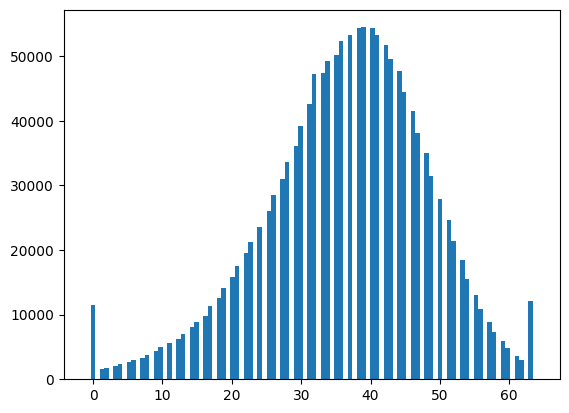

[Orig]


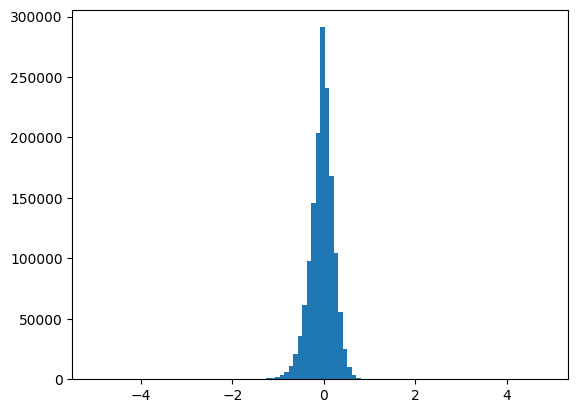

[2023/07/04 01:03:38] Rank:None, Eval at Step [1/600] , FPS 71.9, pred_seen_psnr: 31.63 | 
[2023/07/04 01:03:39] Rank:None, Eval at Step [51/600] , FPS 81.6, pred_seen_psnr: 32.13 | 
[2023/07/04 01:03:41] Rank:None, Eval at Step [101/600] , FPS 83.6, pred_seen_psnr: 32.28 | 
[2023/07/04 01:03:43] Rank:None, Eval at Step [151/600] , FPS 83.4, pred_seen_psnr: 32.34 | 
[2023/07/04 01:03:44] Rank:None, Eval at Step [201/600] , FPS 84.3, pred_seen_psnr: 32.43 | 
[2023/07/04 01:03:46] Rank:None, Eval at Step [251/600] , FPS 84.8, pred_seen_psnr: 32.43 | 
[2023/07/04 01:03:48] Rank:None, Eval at Step [301/600] , FPS 84.7, pred_seen_psnr: 32.42 | 
[2023/07/04 01:03:49] Rank:None, Eval at Step [351/600] , FPS 84.8, pred_seen_psnr: 32.42 | 
[2023/07/04 01:03:51] Rank:None, Eval at Step [401/600] , FPS 84.9, pred_seen_psnr: 32.42 | 
[2023/07/04 01:03:53] Rank:None, Eval at Step [451/600] , FPS 84.7, pred_seen_psnr: 32.42 | 
[2023/07/04 01:03:54] Rank:None, Eval at Step [501/600] , FPS 84.8, pred_

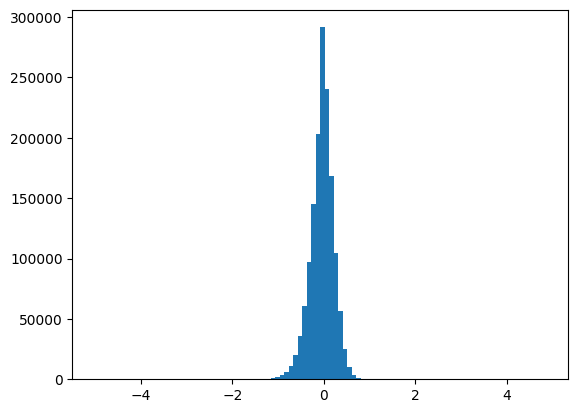

[2023/07/04 01:03:58] Rank:None, Eval at Step [1/600] , FPS 84.5, quant_seen_psnr: 29.71 | 
[2023/07/04 01:04:00] Rank:None, Eval at Step [51/600] , FPS 85.6, quant_seen_psnr: 29.91 | 
[2023/07/04 01:04:02] Rank:None, Eval at Step [101/600] , FPS 85.1, quant_seen_psnr: 29.94 | 
[2023/07/04 01:04:04] Rank:None, Eval at Step [151/600] , FPS 85.4, quant_seen_psnr: 29.96 | 
[2023/07/04 01:04:05] Rank:None, Eval at Step [201/600] , FPS 86.2, quant_seen_psnr: 30.01 | 
[2023/07/04 01:04:07] Rank:None, Eval at Step [251/600] , FPS 85.2, quant_seen_psnr: 29.99 | 
[2023/07/04 01:04:09] Rank:None, Eval at Step [301/600] , FPS 85.1, quant_seen_psnr: 29.98 | 
[2023/07/04 01:04:10] Rank:None, Eval at Step [351/600] , FPS 85.6, quant_seen_psnr: 29.96 | 
[2023/07/04 01:04:12] Rank:None, Eval at Step [401/600] , FPS 86.3, quant_seen_psnr: 29.93 | 
[2023/07/04 01:04:13] Rank:None, Eval at Step [451/600] , FPS 86.8, quant_seen_psnr: 29.92 | 
[2023/07/04 01:04:16] Rank:None, Eval at Step [501/600] , FPS 8

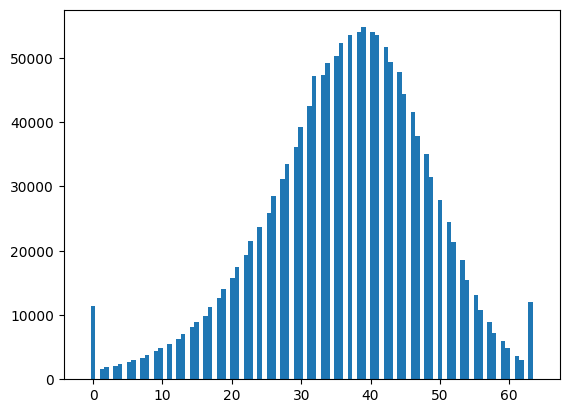

[Orig]


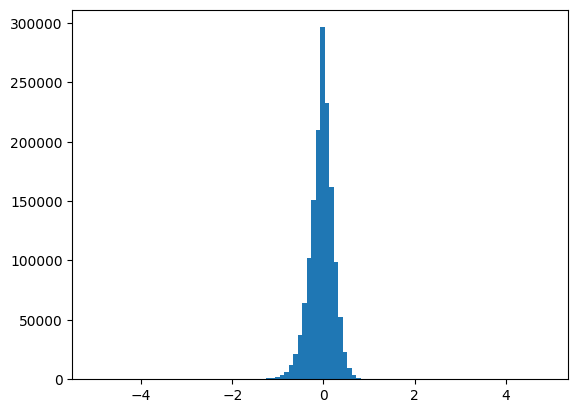

[2023/07/04 01:12:17] Rank:None, Eval at Step [1/600] , FPS 45.1, pred_seen_psnr: 31.56 | 
[2023/07/04 01:12:19] Rank:None, Eval at Step [51/600] , FPS 58.2, pred_seen_psnr: 32.08 | 
[2023/07/04 01:12:21] Rank:None, Eval at Step [101/600] , FPS 55.5, pred_seen_psnr: 32.23 | 
[2023/07/04 01:12:24] Rank:None, Eval at Step [151/600] , FPS 56.9, pred_seen_psnr: 32.29 | 
[2023/07/04 01:12:26] Rank:None, Eval at Step [201/600] , FPS 56.9, pred_seen_psnr: 32.37 | 
[2023/07/04 01:12:28] Rank:None, Eval at Step [251/600] , FPS 61.3, pred_seen_psnr: 32.37 | 
[2023/07/04 01:12:29] Rank:None, Eval at Step [301/600] , FPS 64.7, pred_seen_psnr: 32.36 | 
[2023/07/04 01:12:31] Rank:None, Eval at Step [351/600] , FPS 67.1, pred_seen_psnr: 32.36 | 
[2023/07/04 01:12:33] Rank:None, Eval at Step [401/600] , FPS 68.7, pred_seen_psnr: 32.35 | 
[2023/07/04 01:12:34] Rank:None, Eval at Step [451/600] , FPS 70.7, pred_seen_psnr: 32.35 | 
[2023/07/04 01:12:36] Rank:None, Eval at Step [501/600] , FPS 72.4, pred_

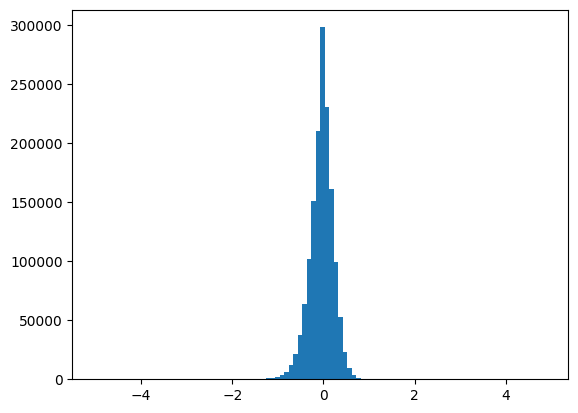

[2023/07/04 01:12:40] Rank:None, Eval at Step [1/600] , FPS 84.8, quant_seen_psnr: 30.09 | 
[2023/07/04 01:12:42] Rank:None, Eval at Step [51/600] , FPS 76.0, quant_seen_psnr: 30.43 | 
[2023/07/04 01:12:44] Rank:None, Eval at Step [101/600] , FPS 76.6, quant_seen_psnr: 30.51 | 
[2023/07/04 01:12:45] Rank:None, Eval at Step [151/600] , FPS 76.8, quant_seen_psnr: 30.55 | 
[2023/07/04 01:12:47] Rank:None, Eval at Step [201/600] , FPS 77.2, quant_seen_psnr: 30.62 | 
[2023/07/04 01:12:49] Rank:None, Eval at Step [251/600] , FPS 77.9, quant_seen_psnr: 30.6 | 
[2023/07/04 01:12:50] Rank:None, Eval at Step [301/600] , FPS 78.1, quant_seen_psnr: 30.58 | 
[2023/07/04 01:12:52] Rank:None, Eval at Step [351/600] , FPS 78.2, quant_seen_psnr: 30.56 | 
[2023/07/04 01:12:54] Rank:None, Eval at Step [401/600] , FPS 78.1, quant_seen_psnr: 30.52 | 
[2023/07/04 01:12:55] Rank:None, Eval at Step [451/600] , FPS 78.3, quant_seen_psnr: 30.51 | 
[2023/07/04 01:12:57] Rank:None, Eval at Step [501/600] , FPS 78

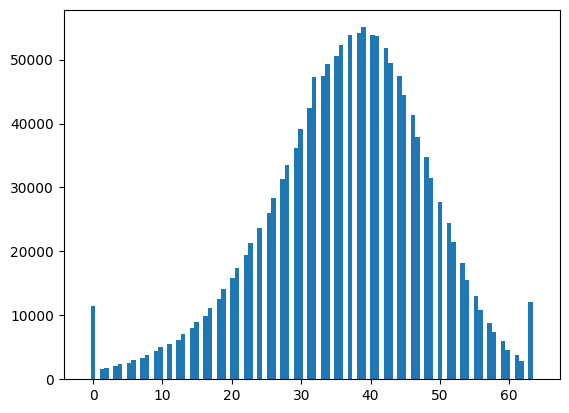

[Orig]


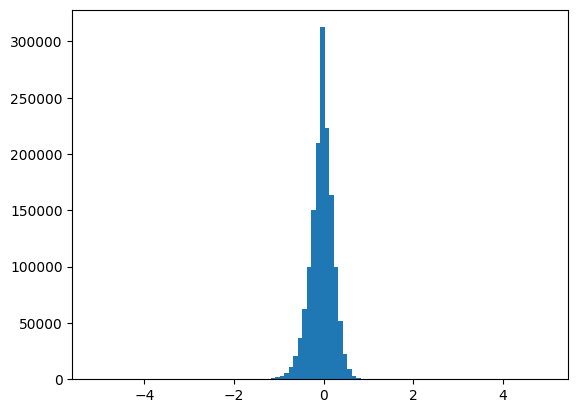

[2023/07/04 01:20:55] Rank:None, Eval at Step [1/600] , FPS 49.2, pred_seen_psnr: 31.46 | 
[2023/07/04 01:20:58] Rank:None, Eval at Step [51/600] , FPS 56.0, pred_seen_psnr: 31.98 | 
[2023/07/04 01:21:00] Rank:None, Eval at Step [101/600] , FPS 57.9, pred_seen_psnr: 32.12 | 
[2023/07/04 01:21:02] Rank:None, Eval at Step [151/600] , FPS 60.6, pred_seen_psnr: 32.16 | 
[2023/07/04 01:21:05] Rank:None, Eval at Step [201/600] , FPS 61.1, pred_seen_psnr: 32.25 | 
[2023/07/04 01:21:07] Rank:None, Eval at Step [251/600] , FPS 60.3, pred_seen_psnr: 32.26 | 
[2023/07/04 01:21:09] Rank:None, Eval at Step [301/600] , FPS 62.9, pred_seen_psnr: 32.24 | 
[2023/07/04 01:21:10] Rank:None, Eval at Step [351/600] , FPS 64.9, pred_seen_psnr: 32.25 | 
[2023/07/04 01:21:12] Rank:None, Eval at Step [401/600] , FPS 67.2, pred_seen_psnr: 32.24 | 
[2023/07/04 01:21:14] Rank:None, Eval at Step [451/600] , FPS 68.9, pred_seen_psnr: 32.23 | 
[2023/07/04 01:21:15] Rank:None, Eval at Step [501/600] , FPS 70.7, pred_

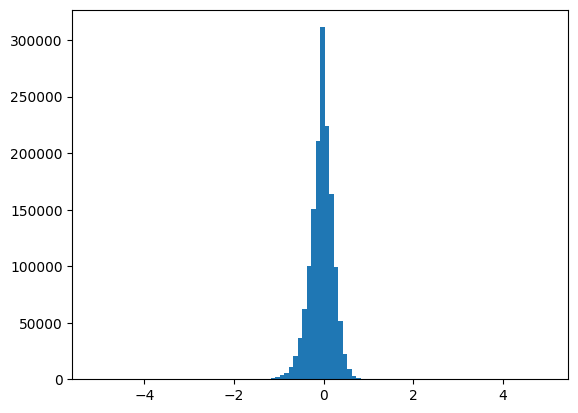

[2023/07/04 01:21:20] Rank:None, Eval at Step [1/600] , FPS 43.4, quant_seen_psnr: 29.49 | 
[2023/07/04 01:21:21] Rank:None, Eval at Step [51/600] , FPS 78.5, quant_seen_psnr: 29.77 | 
[2023/07/04 01:21:23] Rank:None, Eval at Step [101/600] , FPS 76.8, quant_seen_psnr: 29.81 | 
[2023/07/04 01:21:25] Rank:None, Eval at Step [151/600] , FPS 77.5, quant_seen_psnr: 29.83 | 
[2023/07/04 01:21:26] Rank:None, Eval at Step [201/600] , FPS 78.0, quant_seen_psnr: 29.9 | 
[2023/07/04 01:21:28] Rank:None, Eval at Step [251/600] , FPS 78.2, quant_seen_psnr: 29.87 | 
[2023/07/04 01:21:29] Rank:None, Eval at Step [301/600] , FPS 78.2, quant_seen_psnr: 29.83 | 
[2023/07/04 01:21:31] Rank:None, Eval at Step [351/600] , FPS 77.8, quant_seen_psnr: 29.8 | 
[2023/07/04 01:21:33] Rank:None, Eval at Step [401/600] , FPS 77.7, quant_seen_psnr: 29.75 | 
[2023/07/04 01:21:34] Rank:None, Eval at Step [451/600] , FPS 77.5, quant_seen_psnr: 29.71 | 
[2023/07/04 01:21:36] Rank:None, Eval at Step [501/600] , FPS 77.

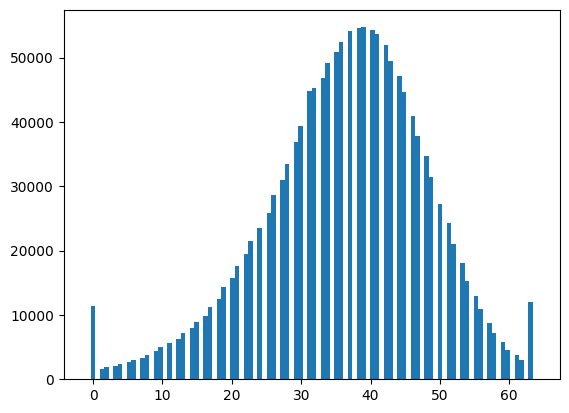

[Orig]


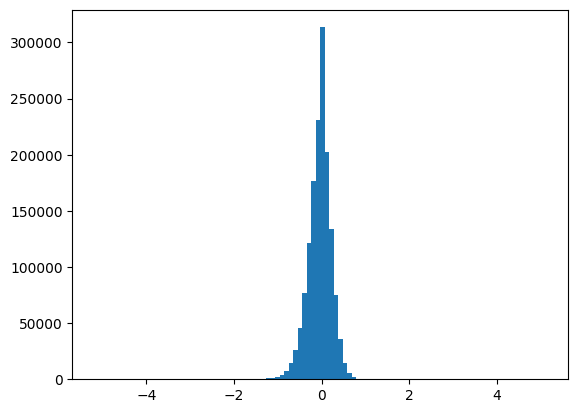

[2023/07/04 01:37:43] Rank:None, Eval at Step [1/600] , FPS 43.4, pred_seen_psnr: 31.21 | 
[2023/07/04 01:37:45] Rank:None, Eval at Step [51/600] , FPS 55.9, pred_seen_psnr: 31.87 | 
[2023/07/04 01:37:47] Rank:None, Eval at Step [101/600] , FPS 60.2, pred_seen_psnr: 32.03 | 
[2023/07/04 01:37:49] Rank:None, Eval at Step [151/600] , FPS 64.5, pred_seen_psnr: 32.07 | 
[2023/07/04 01:37:50] Rank:None, Eval at Step [201/600] , FPS 66.8, pred_seen_psnr: 32.15 | 
[2023/07/04 01:37:52] Rank:None, Eval at Step [251/600] , FPS 68.4, pred_seen_psnr: 32.16 | 
[2023/07/04 01:37:54] Rank:None, Eval at Step [301/600] , FPS 69.5, pred_seen_psnr: 32.13 | 
[2023/07/04 01:37:55] Rank:None, Eval at Step [351/600] , FPS 70.3, pred_seen_psnr: 32.12 | 
[2023/07/04 01:37:57] Rank:None, Eval at Step [401/600] , FPS 70.8, pred_seen_psnr: 32.07 | 
[2023/07/04 01:37:59] Rank:None, Eval at Step [451/600] , FPS 71.4, pred_seen_psnr: 32.04 | 
[2023/07/04 01:38:00] Rank:None, Eval at Step [501/600] , FPS 71.8, pred_

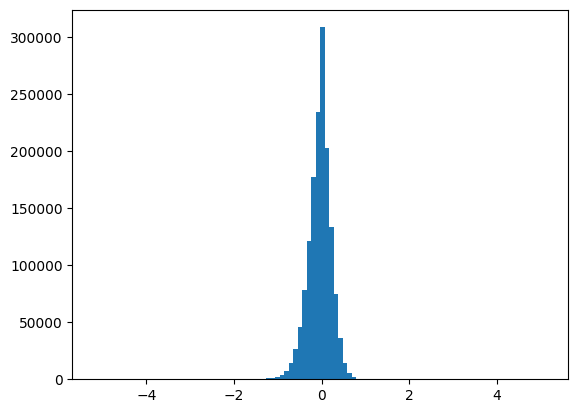

[2023/07/04 01:38:04] Rank:None, Eval at Step [1/600] , FPS 60.1, quant_seen_psnr: 27.86 | 
[2023/07/04 01:38:06] Rank:None, Eval at Step [51/600] , FPS 76.0, quant_seen_psnr: 28.18 | 
[2023/07/04 01:38:08] Rank:None, Eval at Step [101/600] , FPS 75.1, quant_seen_psnr: 28.19 | 
[2023/07/04 01:38:10] Rank:None, Eval at Step [151/600] , FPS 75.4, quant_seen_psnr: 28.2 | 
[2023/07/04 01:38:11] Rank:None, Eval at Step [201/600] , FPS 75.2, quant_seen_psnr: 28.25 | 
[2023/07/04 01:38:13] Rank:None, Eval at Step [251/600] , FPS 75.1, quant_seen_psnr: 28.19 | 
[2023/07/04 01:38:14] Rank:None, Eval at Step [301/600] , FPS 75.3, quant_seen_psnr: 28.15 | 
[2023/07/04 01:38:16] Rank:None, Eval at Step [351/600] , FPS 75.6, quant_seen_psnr: 28.1 | 
[2023/07/04 01:38:18] Rank:None, Eval at Step [401/600] , FPS 75.8, quant_seen_psnr: 28.03 | 
[2023/07/04 01:38:19] Rank:None, Eval at Step [451/600] , FPS 75.9, quant_seen_psnr: 27.99 | 
[2023/07/04 01:38:21] Rank:None, Eval at Step [501/600] , FPS 76.

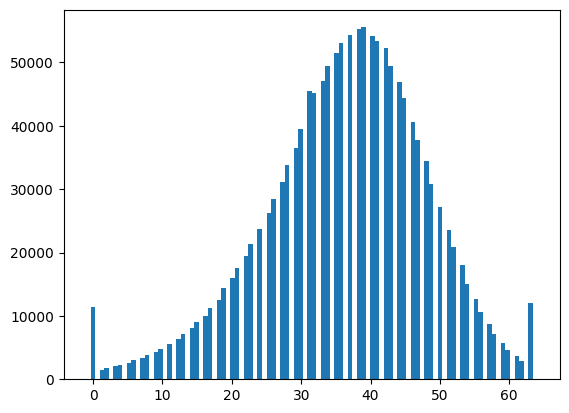

[Orig]


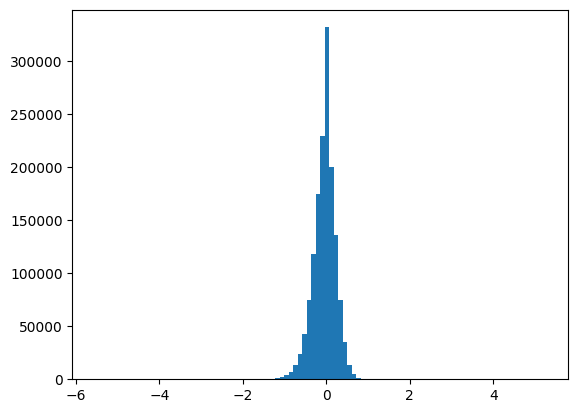

[2023/07/04 01:56:48] Rank:None, Eval at Step [1/600] , FPS 90.5, pred_seen_psnr: 31.07 | 
[2023/07/04 01:56:49] Rank:None, Eval at Step [51/600] , FPS 66.0, pred_seen_psnr: 31.5 | 
[2023/07/04 01:56:51] Rank:None, Eval at Step [101/600] , FPS 67.7, pred_seen_psnr: 31.71 | 
[2023/07/04 01:56:53] Rank:None, Eval at Step [151/600] , FPS 67.2, pred_seen_psnr: 31.81 | 
[2023/07/04 01:56:55] Rank:None, Eval at Step [201/600] , FPS 68.8, pred_seen_psnr: 31.92 | 
[2023/07/04 01:56:57] Rank:None, Eval at Step [251/600] , FPS 68.5, pred_seen_psnr: 31.93 | 
[2023/07/04 01:57:00] Rank:None, Eval at Step [301/600] , FPS 63.7, pred_seen_psnr: 31.88 | 
[2023/07/04 01:57:02] Rank:None, Eval at Step [351/600] , FPS 61.0, pred_seen_psnr: 31.89 | 
[2023/07/04 01:57:04] Rank:None, Eval at Step [401/600] , FPS 60.7, pred_seen_psnr: 31.87 | 
[2023/07/04 01:57:06] Rank:None, Eval at Step [451/600] , FPS 61.1, pred_seen_psnr: 31.87 | 
[2023/07/04 01:57:08] Rank:None, Eval at Step [501/600] , FPS 61.4, pred_s

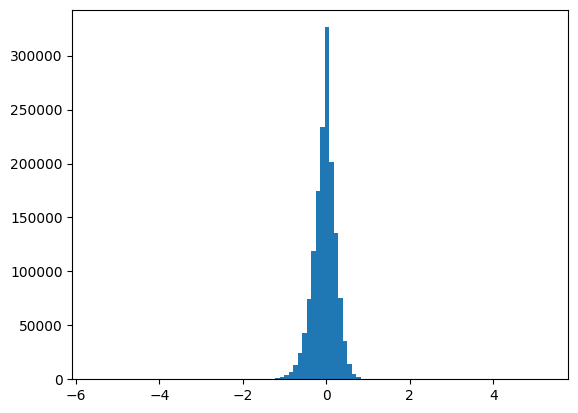

[2023/07/04 01:57:13] Rank:None, Eval at Step [1/600] , FPS 68.2, quant_seen_psnr: 28.26 | 
[2023/07/04 01:57:15] Rank:None, Eval at Step [51/600] , FPS 61.2, quant_seen_psnr: 28.33 | 
[2023/07/04 01:57:17] Rank:None, Eval at Step [101/600] , FPS 62.6, quant_seen_psnr: 28.37 | 
[2023/07/04 01:57:18] Rank:None, Eval at Step [151/600] , FPS 64.3, quant_seen_psnr: 28.41 | 
[2023/07/04 01:57:20] Rank:None, Eval at Step [201/600] , FPS 64.6, quant_seen_psnr: 28.47 | 
[2023/07/04 01:57:22] Rank:None, Eval at Step [251/600] , FPS 64.7, quant_seen_psnr: 28.43 | 
[2023/07/04 01:57:24] Rank:None, Eval at Step [301/600] , FPS 64.4, quant_seen_psnr: 28.4 | 
[2023/07/04 01:57:26] Rank:None, Eval at Step [351/600] , FPS 64.7, quant_seen_psnr: 28.36 | 
[2023/07/04 01:57:28] Rank:None, Eval at Step [401/600] , FPS 65.0, quant_seen_psnr: 28.3 | 
[2023/07/04 01:57:29] Rank:None, Eval at Step [451/600] , FPS 64.8, quant_seen_psnr: 28.28 | 
[2023/07/04 01:57:32] Rank:None, Eval at Step [501/600] , FPS 63.

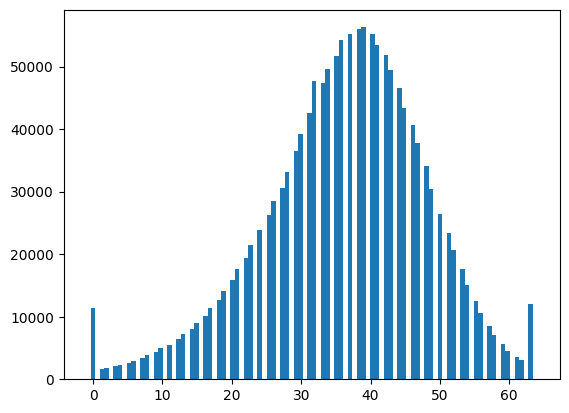

[Orig]


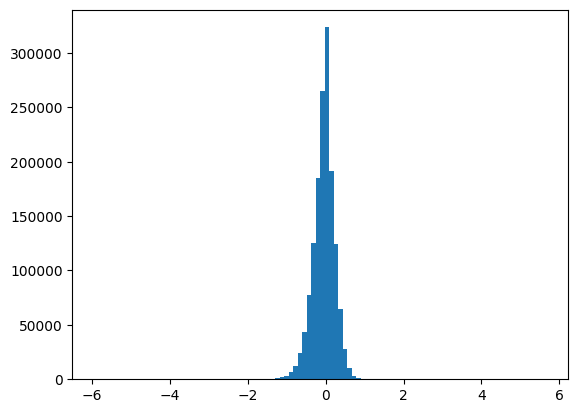

[2023/07/04 02:17:26] Rank:None, Eval at Step [1/600] , FPS 46.7, pred_seen_psnr: 30.9 | 
[2023/07/04 02:17:30] Rank:None, Eval at Step [51/600] , FPS 41.0, pred_seen_psnr: 31.72 | 
[2023/07/04 02:17:33] Rank:None, Eval at Step [101/600] , FPS 40.0, pred_seen_psnr: 31.87 | 
[2023/07/04 02:17:37] Rank:None, Eval at Step [151/600] , FPS 39.8, pred_seen_psnr: 31.93 | 
[2023/07/04 02:17:40] Rank:None, Eval at Step [201/600] , FPS 39.6, pred_seen_psnr: 32.02 | 
[2023/07/04 02:17:44] Rank:None, Eval at Step [251/600] , FPS 39.4, pred_seen_psnr: 32.01 | 
[2023/07/04 02:17:47] Rank:None, Eval at Step [301/600] , FPS 38.7, pred_seen_psnr: 31.97 | 
[2023/07/04 02:17:50] Rank:None, Eval at Step [351/600] , FPS 37.8, pred_seen_psnr: 31.96 | 
[2023/07/04 02:17:53] Rank:None, Eval at Step [401/600] , FPS 39.2, pred_seen_psnr: 31.91 | 
[2023/07/04 02:17:55] Rank:None, Eval at Step [451/600] , FPS 40.9, pred_seen_psnr: 31.9 | 
[2023/07/04 02:17:57] Rank:None, Eval at Step [501/600] , FPS 42.7, pred_se

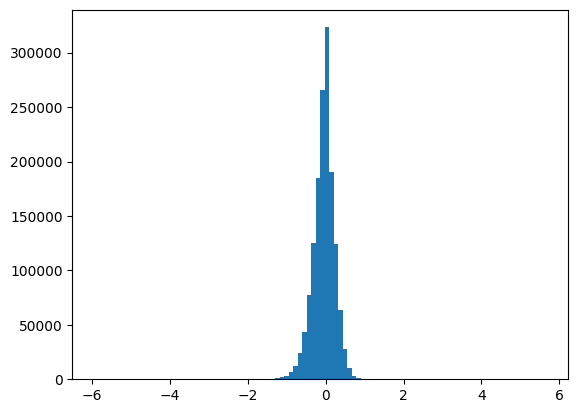

[2023/07/04 02:18:01] Rank:None, Eval at Step [1/600] , FPS 80.4, quant_seen_psnr: 28.84 | 
[2023/07/04 02:18:03] Rank:None, Eval at Step [51/600] , FPS 64.8, quant_seen_psnr: 29.33 | 
[2023/07/04 02:18:04] Rank:None, Eval at Step [101/600] , FPS 66.9, quant_seen_psnr: 29.41 | 
[2023/07/04 02:18:06] Rank:None, Eval at Step [151/600] , FPS 68.8, quant_seen_psnr: 29.44 | 
[2023/07/04 02:18:08] Rank:None, Eval at Step [201/600] , FPS 65.9, quant_seen_psnr: 29.48 | 
[2023/07/04 02:18:10] Rank:None, Eval at Step [251/600] , FPS 64.8, quant_seen_psnr: 29.44 | 
[2023/07/04 02:18:12] Rank:None, Eval at Step [301/600] , FPS 64.2, quant_seen_psnr: 29.42 | 
[2023/07/04 02:18:14] Rank:None, Eval at Step [351/600] , FPS 63.2, quant_seen_psnr: 29.4 | 
[2023/07/04 02:18:16] Rank:None, Eval at Step [401/600] , FPS 62.6, quant_seen_psnr: 29.33 | 
[2023/07/04 02:18:18] Rank:None, Eval at Step [451/600] , FPS 62.9, quant_seen_psnr: 29.32 | 
[2023/07/04 02:18:20] Rank:None, Eval at Step [501/600] , FPS 62

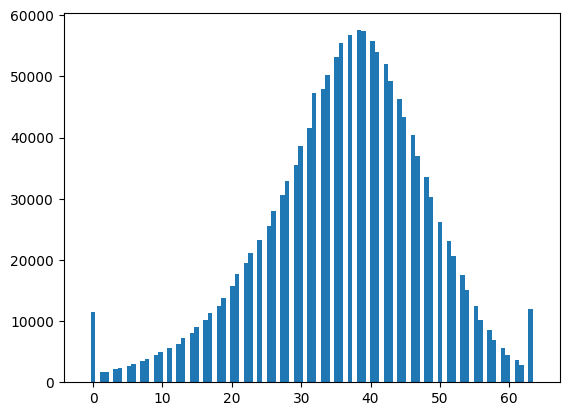

[Orig]


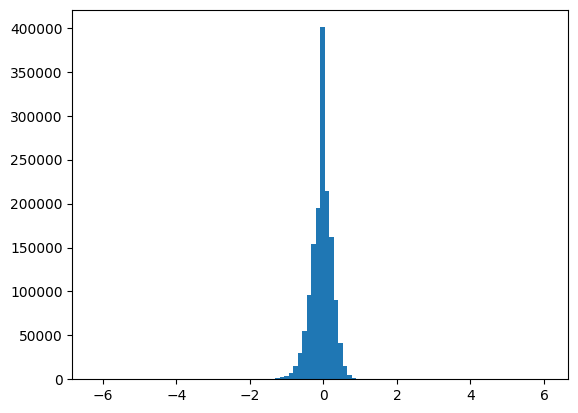

[2023/07/04 02:38:26] Rank:None, Eval at Step [1/600] , FPS 88.7, pred_seen_psnr: 30.85 | 
[2023/07/04 02:38:28] Rank:None, Eval at Step [51/600] , FPS 60.1, pred_seen_psnr: 31.64 | 
[2023/07/04 02:38:30] Rank:None, Eval at Step [101/600] , FPS 58.6, pred_seen_psnr: 31.78 | 
[2023/07/04 02:38:32] Rank:None, Eval at Step [151/600] , FPS 59.6, pred_seen_psnr: 31.84 | 
[2023/07/04 02:38:34] Rank:None, Eval at Step [201/600] , FPS 58.5, pred_seen_psnr: 31.94 | 
[2023/07/04 02:38:37] Rank:None, Eval at Step [251/600] , FPS 58.5, pred_seen_psnr: 31.92 | 
[2023/07/04 02:38:39] Rank:None, Eval at Step [301/600] , FPS 58.4, pred_seen_psnr: 31.86 | 
[2023/07/04 02:38:41] Rank:None, Eval at Step [351/600] , FPS 58.5, pred_seen_psnr: 31.84 | 
[2023/07/04 02:38:43] Rank:None, Eval at Step [401/600] , FPS 58.4, pred_seen_psnr: 31.81 | 
[2023/07/04 02:38:45] Rank:None, Eval at Step [451/600] , FPS 58.3, pred_seen_psnr: 31.81 | 
[2023/07/04 02:38:47] Rank:None, Eval at Step [501/600] , FPS 58.0, pred_

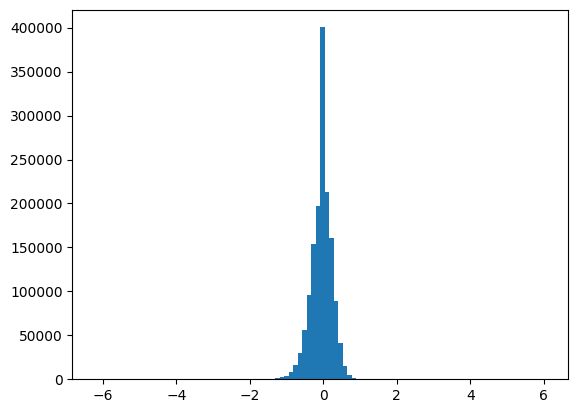

[2023/07/04 02:38:52] Rank:None, Eval at Step [1/600] , FPS 58.4, quant_seen_psnr: 28.74 | 
[2023/07/04 02:38:54] Rank:None, Eval at Step [51/600] , FPS 49.9, quant_seen_psnr: 28.86 | 
[2023/07/04 02:38:57] Rank:None, Eval at Step [101/600] , FPS 47.3, quant_seen_psnr: 28.93 | 
[2023/07/04 02:38:59] Rank:None, Eval at Step [151/600] , FPS 46.7, quant_seen_psnr: 28.96 | 
[2023/07/04 02:39:02] Rank:None, Eval at Step [201/600] , FPS 46.5, quant_seen_psnr: 29.02 | 
[2023/07/04 02:39:05] Rank:None, Eval at Step [251/600] , FPS 46.1, quant_seen_psnr: 28.98 | 
[2023/07/04 02:39:07] Rank:None, Eval at Step [301/600] , FPS 46.0, quant_seen_psnr: 28.94 | 
[2023/07/04 02:39:10] Rank:None, Eval at Step [351/600] , FPS 45.9, quant_seen_psnr: 28.91 | 
[2023/07/04 02:39:13] Rank:None, Eval at Step [401/600] , FPS 45.8, quant_seen_psnr: 28.86 | 
[2023/07/04 02:39:15] Rank:None, Eval at Step [451/600] , FPS 45.9, quant_seen_psnr: 28.84 | 
[2023/07/04 02:39:17] Rank:None, Eval at Step [501/600] , FPS 4

In [ ]:
result = main()

Try brotli on output/new_prune_test_3_2x/prune_test_beauty_8_2x/1_1_1__Dim64_16_FC9_16_KS0_1_5_RED1.2_low12_blk1_1_e801_b1_quant_M8_E6_lr0.001_cosine_0.1_1_0.1_L2_Size1.5_ENC_convnext_5,4,4,3,2_DEC_pshuffel_5,4,4,3,2__shuffle_datagelu1_1/epoch650_ratio0.8900000000000001 
to see if final BPP is good - PSNR is not bad at ~31

- At 89% prune rate (epoch650_ratio0.8900000000000001): 
    - Above is not bad from 5.8MB to 1.8MB, so just 31% of what it was, or a 69% reduction! Still beat HEVC

- At 94% prune we have (ep799_ratio0.9400000000000001_quant_vid):
    - Went from 5.8 to 1.1MB! Even better, so just 19% of what it was, or a 81% reduction!



## output/new_prune_test_3_2x/prune_test_beauty_8_2x/1_1_1__Dim64_16_FC9_16_KS0_1_5_RED1.2_low12_blk1_1_e111_b1_quant_M8_E6_lr0.001_cosine_0.1_1_0.1_L2_Size1.5_ENC_convnext_5,4,4,3,2_DEC_pshuffel_5,4,4,3,2__shuffle_datagelu1_1/epoch20_ratio0.9500000000000001

works quite well - with `MAX_VAL` of 128 only! But at 95% reduction, the performance of quantized vs unquantized is about the same as! At 80% it's much worse, but 95% it's comparable; probably because at high prune rate, most are 0 already.

Here we achieved BPP of 0.0135 and after Brotli it goes down to ~0.0021! 

**Note**:
1. Seems like the `MAX_VAL` AND `rounding` resolution or number of bins of weights is very important, on top of the concentration of weights distribution (lower entropy).
2. Sticking with `MAX_VAL` of `1000` is good / overparameterizing since the `orig` weights will likely fall withint `-10` and `10` and with resolution of 2 decimal places (hundreths), `1000` is sufficient to capture data in a lossless way **POST** rounding.
3. `BPP` doesn't drop even with more zero IF distribution is wide (high entropy).
4. Ideal setting right now seems to be 
    - Lower `BPP` with lower resolution (rather than hundreth, maybe 1/50?; but can stick with hundreth for now)
    - Lower `BPP` with higher pruning that leads to **lower entropy**
    - Maintain `PSNR` by training MORE at later epochs and to incrementally prune.
        - Seem to have achieved >10x reduction with Brotli at `/scratch/kl3866/IVP/HNeRV/output/new_prune_test_2_2x/prune_test_beauty_7_2x/1_1_1__Dim64_16_FC9_16_KS0_1_5_RED1.2_low12_blk1_1_e1_b1_quant_M8_E6_lr0.001_cosine_0.1_1_0.1_L2_Size1.5_ENC_convnext_5,4,4,3,2_DEC_pshuffel_5,4,4,3,2__shuffle_datagelu1_1/ep0_ratio0.96_quant_vid.pth.br` with final BPP of `0.00019722222222222222`
        
BPP problem seems to be under control now, just need to
1. Properly repeat experiment with better code and tracking AND 
2. Solve issue of low PSNR at high compression / prune ratio.

### To do

1. Implement variable training epoch scheduler to emphasize higher prune rate training with more epochs
2. Implement saving of all weights, quantized and otherwise of each eval period
3. Implement easy load / reload with metadata to resume from any prune ratio instances
4. Implement brotli compression as part of eval as well to get final BPP measurement directly.
5. Implement better data logging; consider using W&B.

Then try other ideas to actually improve
1. Quantized training
2. Pos encoding for embeddings
3. 3D Conv
4. Larger model
5. Larger embedding
6. Predict error between frames instead?

In [17]:
sym_bit_dict = {38: 5, 39: 6, 4: 14, 2: 15, 0: 15, 6: 13, 8: 12, 45: 12, 47: 14, 50: 15, 48: 15, 46: 13, 44: 11, 10: 11, 42: 9, 41: 8, 40: 7, 22: 5, 20: 6, 43: 10, 12: 10, 14: 9, 16: 8, 18: 7, 36: 4, 23: 5, 37: 5, 34: 4, 27: 4, 33: 4, 25: 4, 32: 4, 28: 4, 21: 6, 5: 14, 49: 17, 1: 16, 3: 15, 7: 13, 9: 12, 11: 11, 13: 10, 15: 9, 17: 8, 19: 7, 24: 5, 26: 4, 35: 4, 31: 4, 29: 4, 30: 4}
num_freq =  {0: 22, 1: 18, 2: 19, 3: 34, 4: 38, 5: 61, 6: 84, 7: 131, 8: 164, 9: 283, 10: 435, 11: 611, 12: 1006, 13: 1434, 14: 2161, 15: 3090, 16: 4412, 17: 6243, 18: 8607, 19: 12370, 20: 16509, 21: 22818, 22: 31094, 23: 40944, 24: 56485, 25: 100312, 26: 104786, 27: 92551, 28: 100981, 29: 108197, 30: 108771, 31: 107478, 32: 100587, 33: 95239, 34: 91102, 35: 104884, 36: 84051, 37: 45475, 38: 28053, 39: 14880, 40: 7746, 41: 3977, 42: 1939, 43: 940, 44: 414, 45: 197, 46: 117, 47: 41, 48: 29, 49: 12, 50: 24}

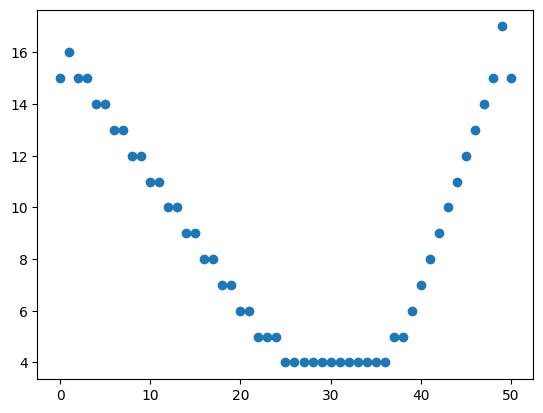

In [26]:
plt.scatter(x=sym_bit_dict.keys(),y=sym_bit_dict.values())

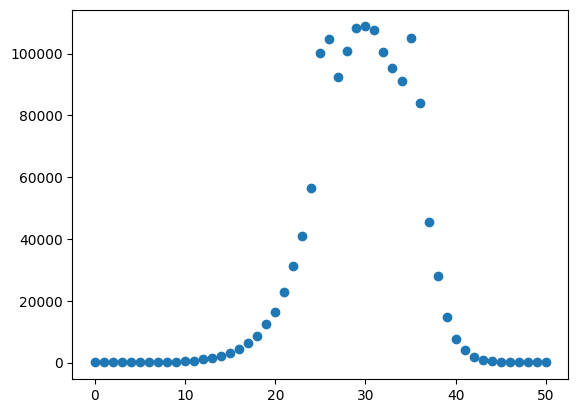

In [27]:
plt.scatter(x=num_freq.keys(),y=num_freq.values())

___
### Check Weights

In [12]:
root = '/scratch/kl3866/IVP/HNeRV/output/new_prune_test_2_2x/prune_test_beauty_7_2x/1_1_1__Dim64_16_FC9_16_KS0_1_5_RED1.2_low12_blk1_1_e90_b1_quant_M8_E6_lr0.001_cosine_0.1_1_0.1_L2_Size1.5_ENC_convnext_5,4,4,3,2_DEC_pshuffel_5,4,4,3,2__shuffle_datagelu1_1/ep89_ratio0.9_quant_vid.pth'

In [14]:
load = torch.load(root)
load.keys()

dict_keys(['embed', 'model'])

In [44]:
#Check model distribution
weights = []
scale = []
tmin = []

for k,v in load['model'].items():
    weights.append(v['quant'].ravel())
    scale.append(v['scale'].ravel())
    tmin.append(v['min'].ravel())

In [45]:
weights = torch.cat(weights).cpu()
scale = torch.cat(scale).cpu()
tmin = torch.cat(tmin).cpu()

In [39]:
weights.shape,scale.shape,tmin.shape

(torch.Size([1492656]), torch.Size([18]), torch.Size([18]))

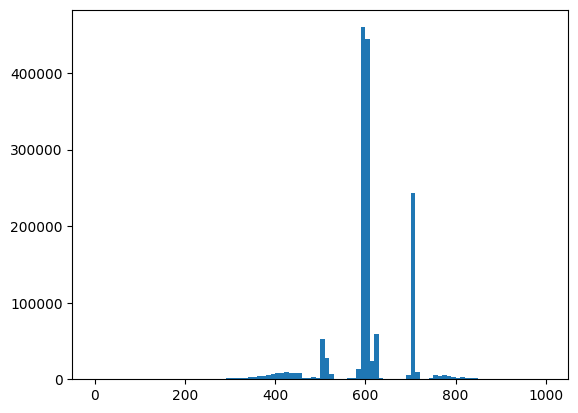

In [48]:
#Look at hist
a,b,c = plt.hist(weights,bins=100,align='mid')
plt.show()

**Notes**: Yes! It's correct! And the size is super small at ~1e-3 (beat HEVC by size)! But PSNR is bad, need to improve somehow

___
### Experiment with Huffman Coding

In [101]:
#Case 1
# quant_v_list = np.arange(100)
# quant_v_list = np.repeat(quant_v_list,10).astype(int)

# #Case 2
# quant_v_list = np.zeros(800)
# temp = np.repeat(np.arange(100),2)
# quant_v_list = np.concatenate((quant_v_list,temp)).astype(int)

#Case 3
quant_v_list = np.zeros(800) + 50
temp = np.repeat(np.arange(100),2)
quant_v_list = np.concatenate((quant_v_list,temp)).astype(int)


# get the element name and its frequency
unique, counts = np.unique(quant_v_list, return_counts=True)
num_freq = dict(zip(unique, counts))


In [98]:
quant_v_list.shape

(1000,)

In [91]:
num_freq

{0: 5,
 1: 5,
 2: 5,
 3: 5,
 4: 5,
 5: 5,
 6: 5,
 7: 5,
 8: 5,
 9: 5,
 10: 5,
 11: 5,
 12: 5,
 13: 5,
 14: 5,
 15: 5,
 16: 5,
 17: 5,
 18: 5,
 19: 5,
 20: 5,
 21: 5,
 22: 5,
 23: 5,
 24: 5,
 25: 5,
 26: 5,
 27: 5,
 28: 5,
 29: 5,
 30: 5,
 31: 5,
 32: 5,
 33: 5,
 34: 5,
 35: 5,
 36: 5,
 37: 5,
 38: 5,
 39: 5,
 40: 5,
 41: 5,
 42: 5,
 43: 5,
 44: 5,
 45: 5,
 46: 5,
 47: 5,
 48: 5,
 49: 5,
 50: 505,
 51: 5,
 52: 5,
 53: 5,
 54: 5,
 55: 5,
 56: 5,
 57: 5,
 58: 5,
 59: 5,
 60: 5,
 61: 5,
 62: 5,
 63: 5,
 64: 5,
 65: 5,
 66: 5,
 67: 5,
 68: 5,
 69: 5,
 70: 5,
 71: 5,
 72: 5,
 73: 5,
 74: 5,
 75: 5,
 76: 5,
 77: 5,
 78: 5,
 79: 5,
 80: 5,
 81: 5,
 82: 5,
 83: 5,
 84: 5,
 85: 5,
 86: 5,
 87: 5,
 88: 5,
 89: 5,
 90: 5,
 91: 5,
 92: 5,
 93: 5,
 94: 5,
 95: 5,
 96: 5,
 97: 5,
 98: 5,
 99: 5}

In [102]:
# generating HuffmanCoding table
codec = HuffmanCodec.from_data(quant_v_list)
sym_bit_dict = {}
for k, v in codec.get_code_table().items():
    sym_bit_dict[k] = v[0]

# total bits for quantized embed + model weights
total_bits = 0
for num, freq in num_freq.items():
    total_bits += freq * sym_bit_dict[num]
bits_per_param = total_bits / len(quant_v_list)

In [78]:
bits_per_param #case 1

6.73

In [83]:
bits_per_param #case 2

2.33

In [103]:
bits_per_param #case 3

2.33

In [ ]:
Looks like #zeros does help! So issue is that quantized tensor is not as concentrated around a single value
# e.g. 0 as much as the unquantized tensor!